# SARIMA With calls

In [ ]:
# https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

In [ ]:
import warnings
warnings.simplefilter(action='ignore')

In [1]:
from datetime import datetime, date 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import itertools

In [2]:
import platform
print(platform.python_version())

3.8.5


### Load and inspect the data:

In [14]:
df = pd.read_csv('/Users/kata/Desktop/GitHub/standby_duty_forecasting/sickness_table.csv') #, index_col=0)
df['date'] = pd.to_datetime(df['date'])
df.head()

,Unnamed: 0,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
0,0,2016-04-01,73,8154.0,1700,90,4.0,0.0
1,1,2016-04-02,64,8526.0,1700,90,70.0,0.0
2,2,2016-04-03,68,8088.0,1700,90,0.0,0.0
3,3,2016-04-04,71,7044.0,1700,90,0.0,0.0
4,4,2016-04-05,63,7236.0,1700,90,0.0,0.0


In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df.calls, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 1, 12) yields the lowest AIC value of 18858.03. Therefore we should consider this to be optimal option.

In [4]:
# fitting the arima model

mod = sm.tsa.statespace.SARIMAX(df.calls,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])
#print(results.summary())

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1648      0.032      5.081      0.000       0.101       0.228
ma.L1         -0.9232      0.014    -68.170      0.000      -0.950      -0.897
ar.S.L12      -0.0715      0.030     -2.357      0.018      -0.131      -0.012
ma.S.L12      -0.9864      0.017    -59.160      0.000      -1.019      -0.954
sigma2      1.067e+06   5.22e+04     20.452      0.000    9.65e+05    1.17e+06


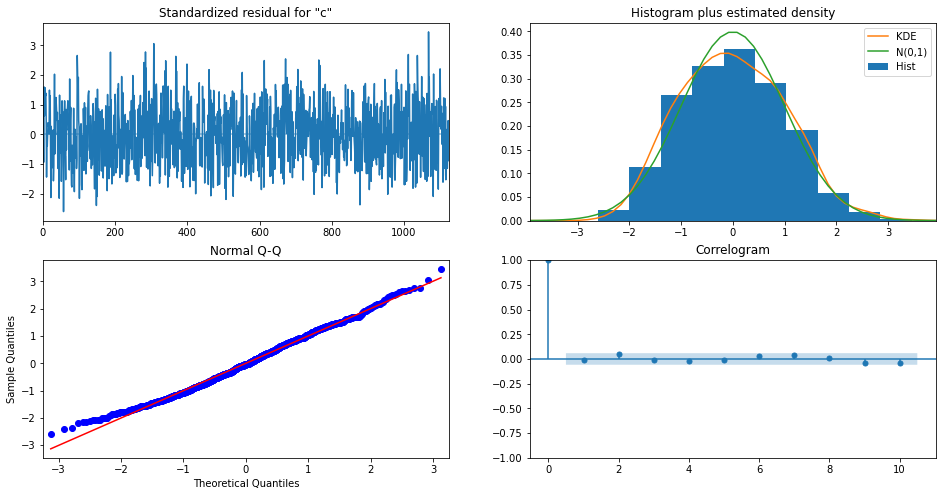

In [5]:
# run model diagnostics to investigate any unusual behavior.
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [15]:
df = df[['date', 'calls']]
#df = df.set_index('date')
#df.index

<AxesSubplot:>

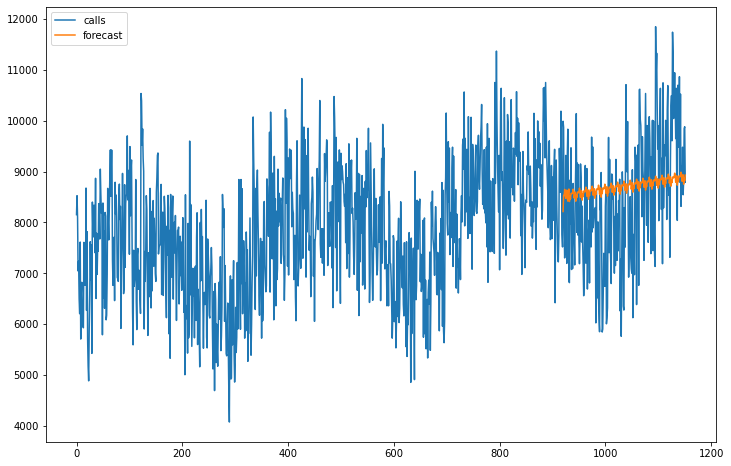

In [7]:
#Validating forecasts

df['forecast']=results.predict(start=920, dynamic=True)
df[['calls','forecast']].plot(figsize=(12,8))

In [21]:
df = df.drop(columns=['date'])

KeyError: "['date'] not found in axis"

In [22]:
df.head()

,calls
0,8154.0
1,8526.0
2,8088.0
3,7044.0
4,7236.0


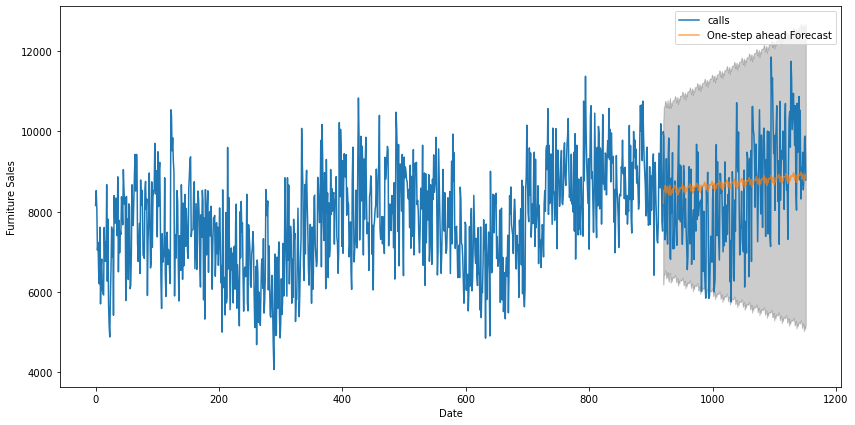

In [26]:
pred = results.get_prediction(start=920, dynamic=True)
pred_ci = pred.conf_int()
ax = df.iloc[0:].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [45]:
calls_forecasted = pred.predicted_mean
calls_true = df.iloc[920:]
observed_calls = calls_true['calls'].squeeze()
mse = ((calls_forecasted - observed_calls) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1632709.15
